# **Bayesian Machine Learning Summer Camp (ICAS - UNSAM)**

#### Segment an astronomical image using a U-Net and extract the arcs of a strong gravitational lens from the background.

See more about U-nets in https://en.wikipedia.org/wiki/U-Net

This notebook was inspired in https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras import datasets, layers, models
from scipy.ndimage import zoom
import json
!pip install gdown
!pip install deeplenstronomy
np.random.seed(42)

from deeplenstronomy.visualize import view_image


# Mount google drive and download the files

It may ask your permission to access your g-drive

In [8]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Check if the data is already in your folder. If it is not, download it

%cd "/content"
!ls
import os.path
if os.path.exists("LSST"):
   %cd lensdata
   !ls
else:
   !gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1e3kUUyYFfgDd1NePVSYyEMwm0EhO-gDa?usp=sharing

/content
drive  LSST  sample_data
[Errno 2] No such file or directory: 'lensdata'
/content
drive  LSST  sample_data


In [10]:
# The data we will be using is given by a metadata (.csv) file with true (actual) lens mass parameters from simulations and the images in an npy format
# Here, we set the paths for both files

dataset_prepath = "./LSST"
metadata_file = "CONFIGURATION_1_metadata.csv"
images_file = "CONFIGURATION_1_images.npy"

images_path = os.path.join(dataset_prepath, images_file)
metadata_path = os.path.join(dataset_prepath, metadata_file)
metadata = pd.read_csv(metadata_path)

images = np.load(images_path)
# selecting only one bandpass
images = images[:, 2, :, :]

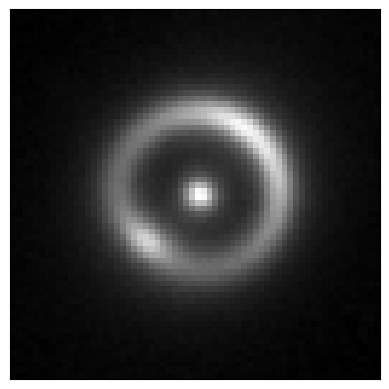

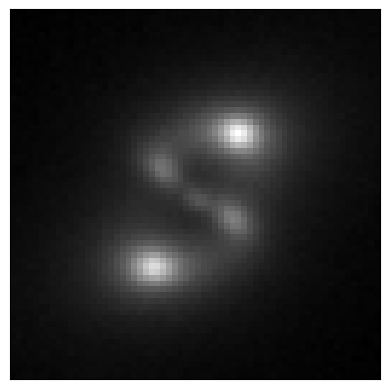

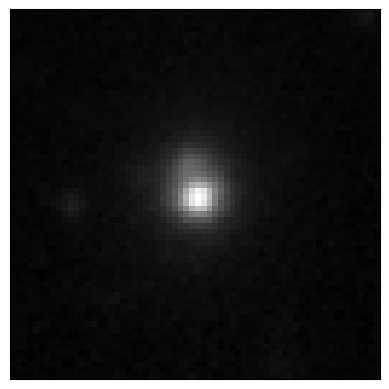

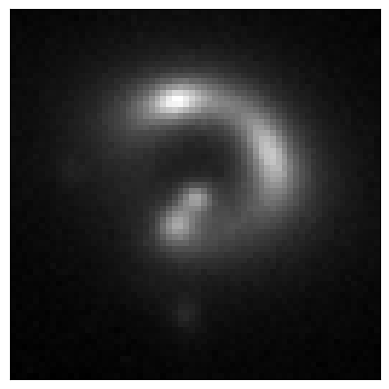

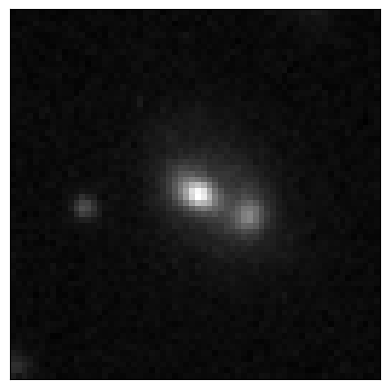

In [11]:
# Visualizing our images:
for i in range(0, 5):
    view_image(images[i], cmap='gray')

In [12]:
#Check if the segmentation images are already in your folder. If it is not, download it
%cd "/content"
!ls
import os.path
if os.path.exists("segmentation_maps"):
   %cd lensdata
   !ls
else:
   !gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1xQ1XRQPA2Mb0kxTB4aEGhZT_ZAUL5Pk7?usp=sharing

/content
drive  LSST  sample_data
Retrieving folder list
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Processing file 130u9Tp2G7PjbYydTPZwVso5XvErRQoqW segmentations.npy
Retrieving folder list completed
Building directory structure
Building directory structure completed
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-14

In [13]:
# Load our segmentation maps. Here we dont have metadata
segmentation_prepath = "./segmentation_maps"
segmentation_file = "segmentations.npy"

segmentation_path = os.path.join(segmentation_prepath, segmentation_file)
segmentations = np.load(segmentation_path)

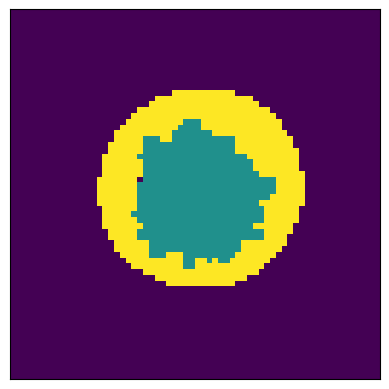

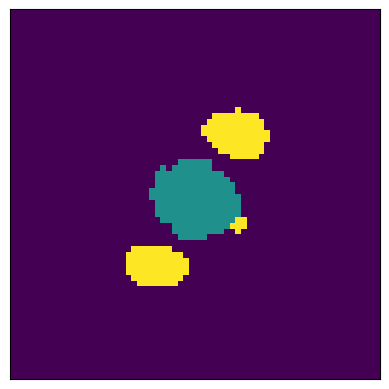

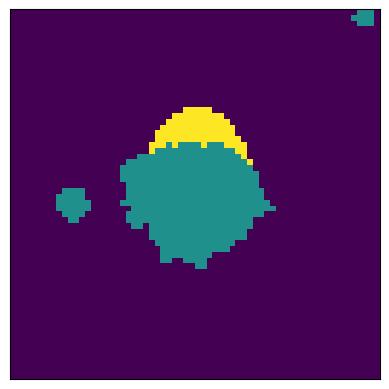

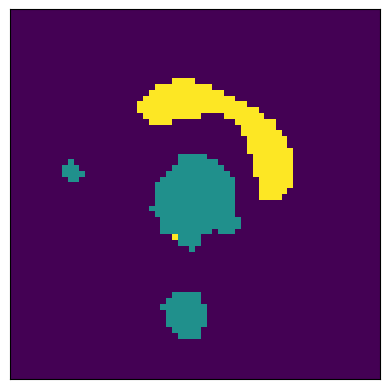

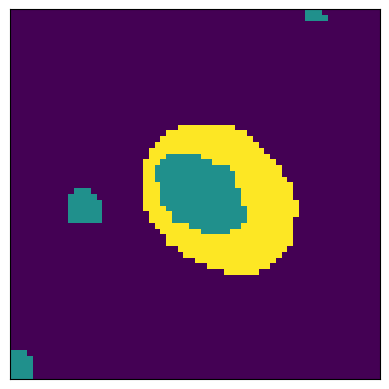

In [14]:
# Visualizing our segmentation maps:
for i in range(0, 5):
    view_image(segmentations[i])

In [ ]:
# split our data in training and test dataset with ration 90 - 10 %
metadata_train, metadata_test = train_test_split(metadata, test_size=0.1)
print(f"Training dataset length: {len(metadata_train)}")
print(f"Test dataset length: {len(metadata_test)}")

Training dataset length: 2249
Test dataset length: 250


In [ ]:
# split our data in training and validation dataset with ration 90 - 10 %
metadata_train, metadata_val = train_test_split(metadata_train, test_size=0.1)
print(f"Training dataset length: {len(metadata_train)}")
print(f"Test dataset length: {len(metadata_test)}")
print(f"Validation dataset length: {len(metadata_val)}")

Training dataset length: 2024
Test dataset length: 250
Validation dataset length: 225


In [ ]:
# Select the images according to the training, validation, and test datasets indexes in the metadata dataframe and converts to numpy arrays
# In order to set our input array to (N, 1, 64, 64) we use reshape instead of reshape now
x_train = images[metadata_train.index.values]
y_train = segmentations[metadata_train.index.values]
x_train = x_train.reshape(-1, 64, 64, 1)
y_train = y_train.reshape(-1, 64, 64, 1)

x_val = images[metadata_val.index.values]
y_val = segmentations[metadata_val.index.values]
x_val = x_val.reshape(-1, 64, 64, 1)
y_val = y_val.reshape(-1, 64, 64, 1)

x_test = images[metadata_test.index.values]
y_test = segmentations[metadata_test.index.values]
x_test = x_test.reshape(-1, 64, 64, 1)
y_test = y_test.reshape(-1, 64, 64, 1)


In [ ]:
# Our Deep learning model. Here, built in blocks
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(64,64,1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
# Set our model and compile
unet_model = model = build_unet_model()

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

In [ ]:
# Summary of the Netwoork: with layers, shapes and number of parameters
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# batch size and epochs you may want to train
batch_size = 32
epochs = 30
# Training our CNN
history = unet_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/30
64/64 [==============================] - 36s 199ms/step - loss: 10.2184 - accuracy: 0.7799 - val_loss: 0.4318 - val_accuracy: 0.8550
Epoch 2/30
64/64 [==============================] - 9s 147ms/step - loss: 0.3089 - accuracy: 0.8843 - val_loss: 0.2892 - val_accuracy: 0.8871
Epoch 3/30
64/64 [==============================] - 9s 148ms/step - loss: 0.2715 - accuracy: 0.8922 - val_loss: 0.2524 - val_accuracy: 0.8968
Epoch 4/30
64/64 [==============================] - 10s 149ms/step - loss: 0.2579 - accuracy: 0.8979 - val_loss: 0.2886 - val_accuracy: 0.9009
Epoch 5/30
64/64 [==============================] - 10s 150ms/step - loss: 0.2299 - accuracy: 0.9057 - val_loss: 0.2415 - val_accuracy: 0.8940
Epoch 6/30
64/64 [==============================] - 10s 152ms/step - loss: 0.2296 - accuracy: 0.9069 - val_loss: 0.2242 - val_accuracy: 0.8977
Epoch 7/30
64/64 [==============================] - 10s 152ms/step - loss: 0.2111 - accuracy: 0.9154 - val_loss: 0.2352 - val_accuracy: 0.9172


# **Test your Knowledge! 💻**

1.   Run this notebook;

2.   Create a matplotlib plot to visualize the training and validation set *loss* per *epoch* and *accuracy* of the segmentations;

3.   Check the Input segmentations and the outputs from the U-net;

In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("$\log_{10}{(Loss)}$")
    plt.yscale('log',base=10)
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

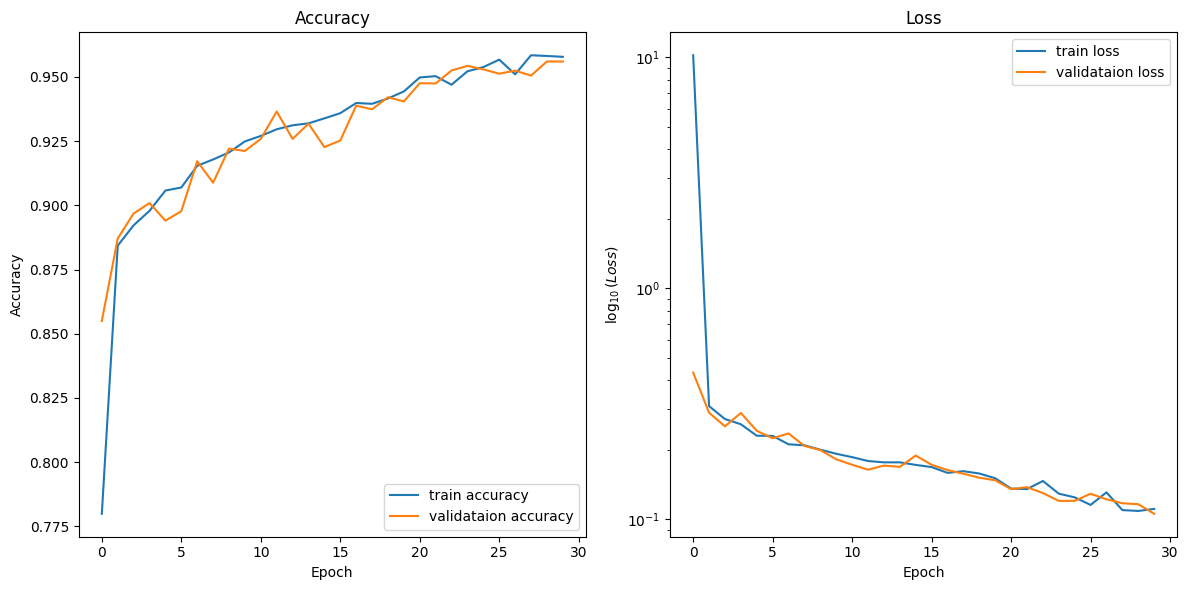

In [ ]:
# Display learning curves
display_learning_curves(history)

In [ ]:
pred_mask = unet_model.predict(x_test)
mask = tf.argmax(pred_mask, axis=-1)

8/8 [==============================] - 3s 379ms/step


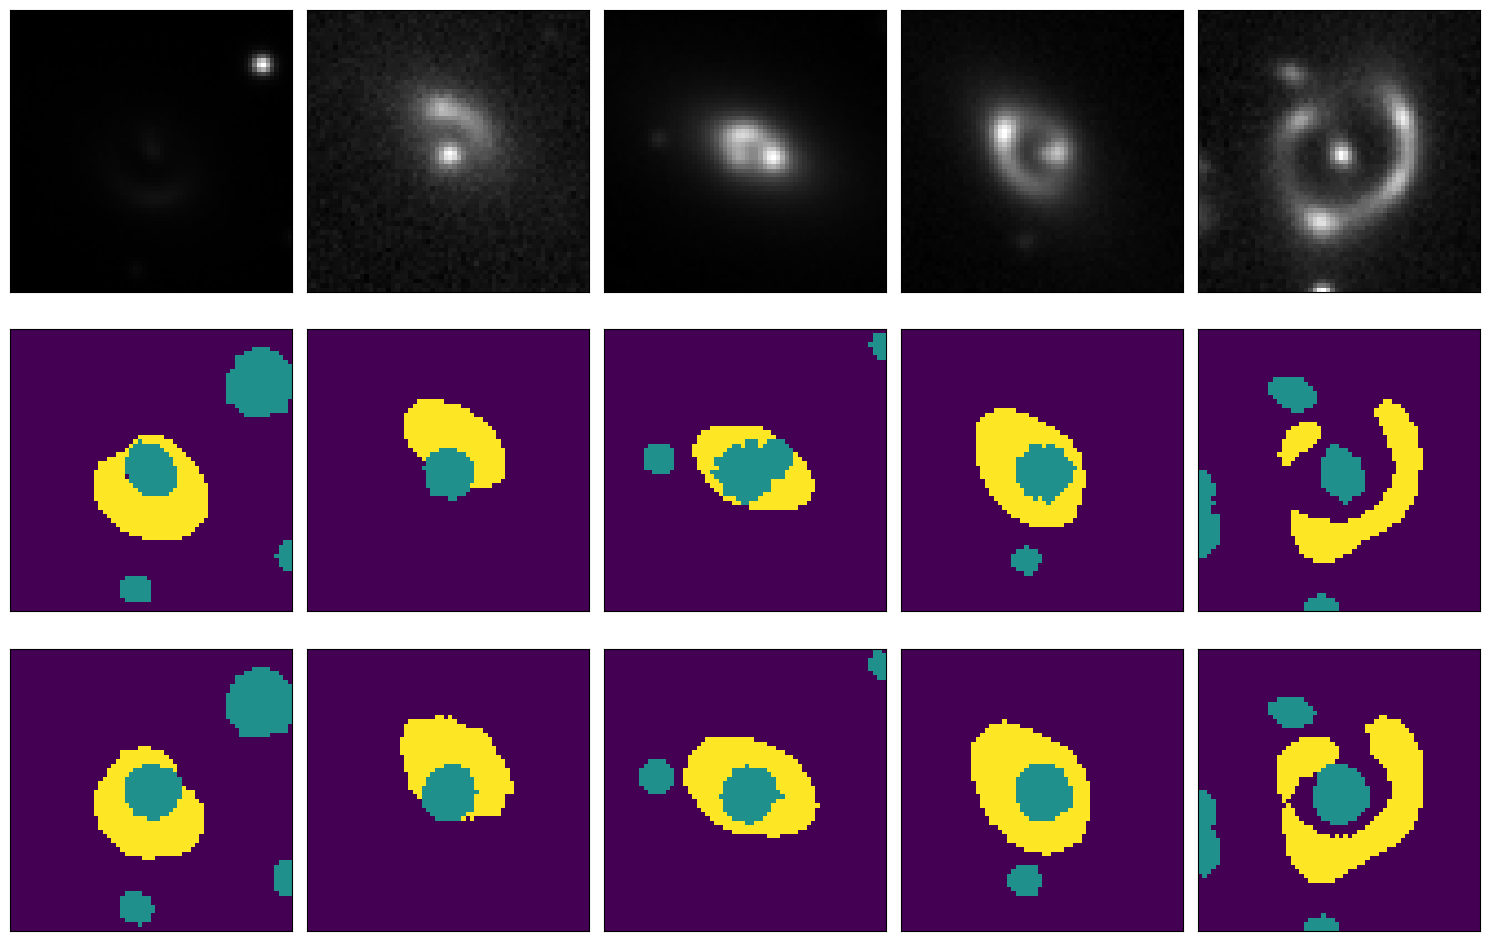

In [ ]:
num_examples = 5

sample_indices = np.random.choice(len(x_test), num_examples, replace=False)

# Restante do seu código
fig, axes = plt.subplots(3, num_examples, figsize=(15, 10))
for i in range(num_examples):
    idx = sample_indices[i]

    ax = axes[0, i]
    ax.imshow(x_test[idx], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    #ax.set_title('Imagem')

    ax = axes[1, i]
    ax.imshow(y_test[idx])
    #ax.set_title('Mapa de Segmentação Verdadeiro')
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[2, i]
    ax.imshow(mask[idx])
    #ax.set_title('Mapa de Segmentação Predito')
    ax.set_xticks([])
    ax.set_yticks([])

# Ajuste o layout do gráfico
plt.tight_layout()
plt.show()